In [1]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
from aesara import shared as tshared
import aesara.tensor as tt
from aesara import function, printing
import arviz as az

# Random seed
np.random.seed(713)

In [2]:
import matplotlib

%matplotlib inline

matplotlib.rcParams.update(
    {"font.size": 16, "axes.labelsize": 24, "axes.titlesize": 18, "text.usetex": True,
    "xtick.major.width": 1.5, "xtick.minor.width": 1.2, "ytick.major.width": 1.5, "ytick.minor.width": 1.2,
    "legend.fontsize": 18}
)

matplotlib.rcParams['figure.dpi']= 150

# colors to use
c_flatirons = '#8B2131'
c_sunshine = '#CA9500'
c_skyline = '#1D428A'
c_midnight = '#0E2240'

colors = [c_flatirons, c_sunshine, c_skyline, c_midnight]

## Infer dGMGP Emulation errors as a function of both L1 and L2


In [3]:
# (LF points, HF points, mean errors, stds)
data = np.loadtxt("../budget_size/dgmgp_bugdget_all_z.txt")

The parametric model is

$$
\mathrm{error} = \theta \cdot n_\mathrm{LF}^{- \nu / d} + n_\mathrm{HF}^{- \nu / d}
$$

In [4]:
x_train = data[:, [0, 1]] # (HF, LF) pairs
y_train = data[:, [2]]    # predicted error
y_sigma = data[:, [3]]    # predicted errors' sigma (std over test examples)

# dimensionality of the emulator
d = 5

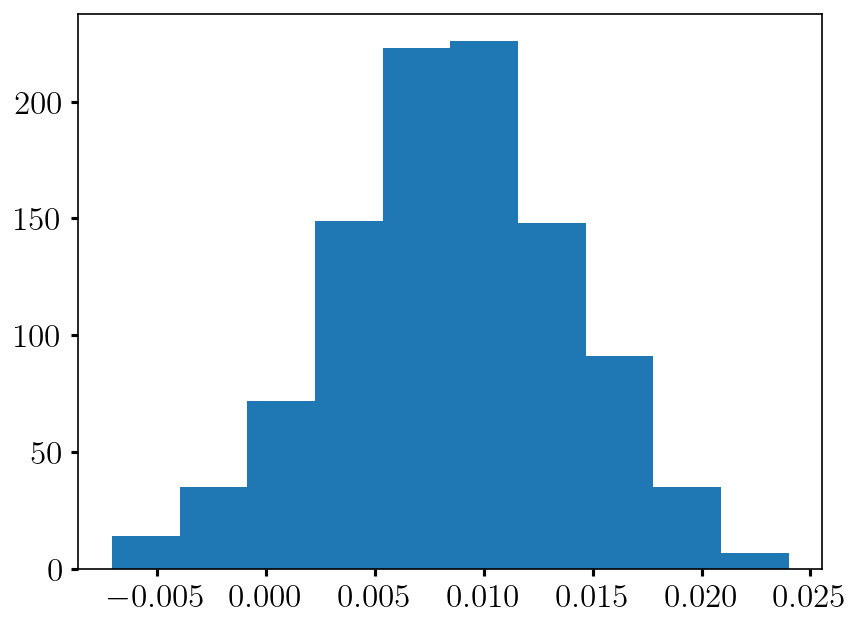

In [5]:
plt.hist(pm.Normal.dist(mu=y_train.mean(), sigma=y_train.std(), size=1000).eval());

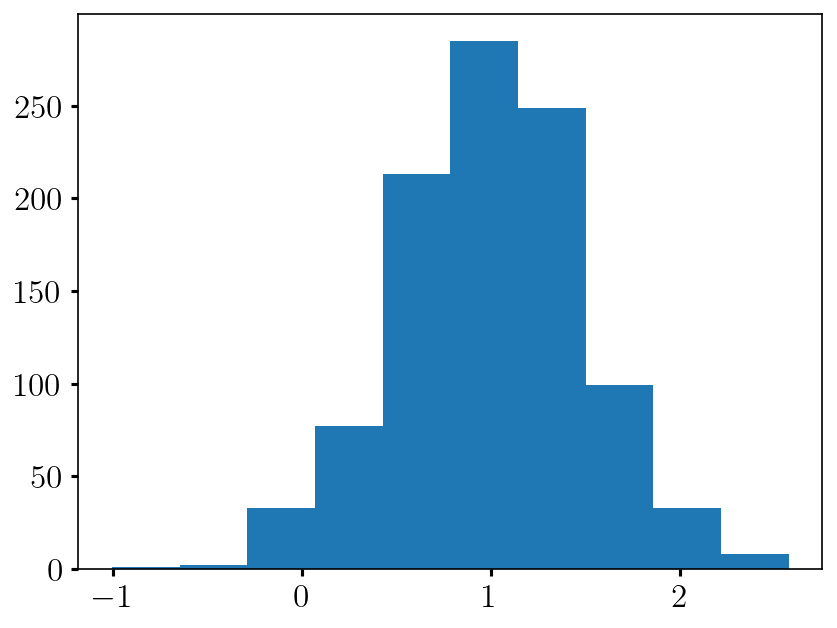

In [6]:
# sbird: highly informed prior for rho
plt.hist(pm.Normal.dist(mu=1, sigma=0.5, size=1000).eval());

## Prior for rho

Perhaps a better way is to get the prior values of rho from the trained GPs.

To test:
1. multiple redshifts
2. How this will benefit other people's emulators?
3. Extend to GMGP

## Inference for dGMGP all redshifts

In [7]:
with pm.Model() as budget_model:
    # Mean emulation error
    theta = pm.Normal("theta", mu=y_train.mean(), sigma=y_train.std())
    # theta = pm.LogNormal("theta", mu=np.log(y_train.mean()), sigma=0.5)

    # Correlation parameter
    # rho   = pm.Uniform("rho", 0, 50)
    # rho1   = pm.LogNormal("rho1", 0, 0.5)
    # rho2   = pm.LogNormal("rho2", 0, 0.5)
    rho1   = pm.Normal("rho1", 1, 1)
    rho2   = pm.Normal("rho2", 1, 1)

    # Observational noise
    # sigma = pm.LogNormal("obs_noise", 0, 1)

    # Spectral index for the power-law relation
    nu1 = pm.LogNormal("nu1", 0, 1)
    nu2 = pm.LogNormal("nu2", 0, 1)
    nu0 = pm.LogNormal("nu0", 0, 1)

    y = theta * (
        rho1 * x_train[:, 1] ** (- nu1 / d) + 
        rho2 * x_train[:, 1] ** (- nu2 / d) +
        x_train[:, 0] ** (- nu0 / d)
    )

    pm.Normal(
        "likelihood",
        mu=y,
        sigma=y_sigma[:, 0],
        observed=y_train[:, 0]
    )

In [8]:
with budget_model:
    start = {
        "theta" : y_train.mean(),
        "rho1"  : 1,
        "rho2"  : 1,
        "nu1" : 6,
        "nu2" : 6,
        "nu0" : 6,
    }

    trace = pm.sample(10000, tune=35000, initvals=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, rho1, rho2, nu1, nu2, nu0]


Sampling 4 chains for 35_000 tune and 10_000 draw iterations (140_000 + 40_000 draws total) took 166 seconds.


In [9]:
# Normal("rho", 1, 0.5): likelihood: 3.93283288
# LogNormal("rho", 0, 0.5): likelihood: 3.9477437
# Normal("rho", 1, 1): likelihood: 3.94582063
# LogNormal("rho", 0, 1): likelihood: 3.96781832

# theta = pm.LogNormal("theta", mu=y_train.mean(), sigma=y_train.std() * 2): likelihood: 3.97154675
trace.log_likelihood.likelihood.median()

<xarray.DataArray 'likelihood' ()>
array(5.50430334)

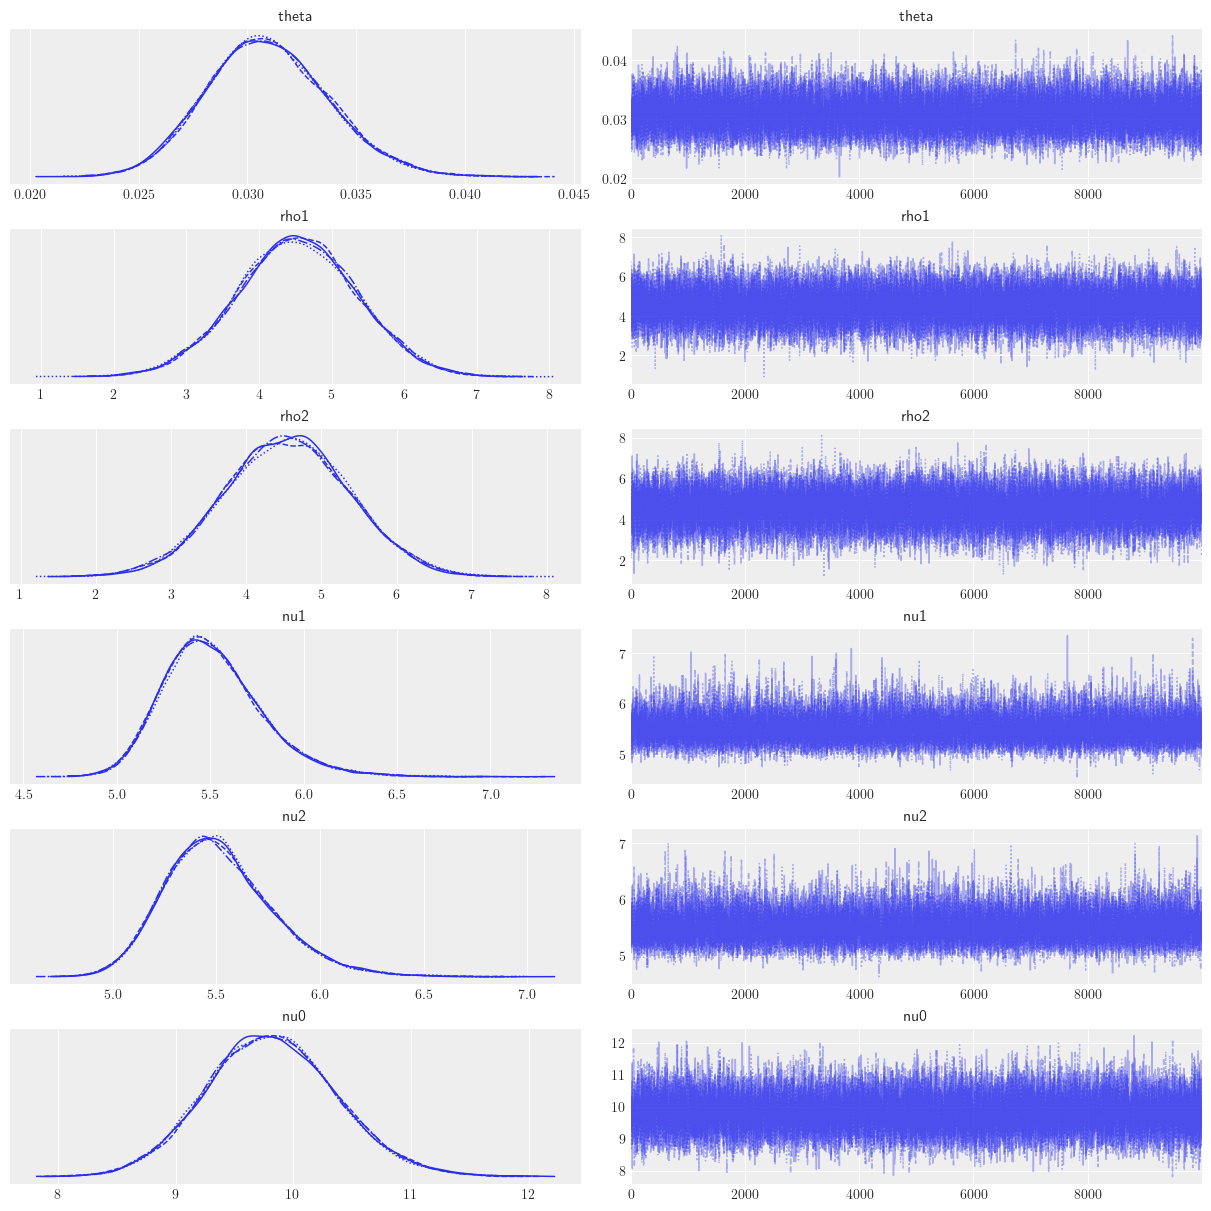

In [10]:
# plotting setting to make the arviz plots look less buggy
az.style.use("arviz-darkgrid")

with budget_model:
    rvs = [
        "theta",
        "rho1",
        "rho2",
        "nu1",
        "nu2",
        "nu0",
        # "obs_noise"
    ]

    _ = az.plot_trace(trace, var_names=rvs)
    
# plt.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/budget_mcmc_chains.pdf", bbox_inches='tight', pad_inches=0.075)


## Posterior preditions

In [13]:
# shared parameters
n_hf = x_train[:, 0]
n_lf = x_train[:, 1]
y_true = y_train[:, 0]

In [14]:
def get_quantiles(trace) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # Finding the quantiles
    theta_lower, theta_median, theta_upper = np.quantile(trace.posterior["theta"], [0.25, 0.5, 0.75])
    rho1_lower, rho1_median, rho1_upper    = np.quantile(trace.posterior["rho1"], [0.25, 0.5, 0.75])
    rho2_lower, rho2_median, rho2_upper    = np.quantile(trace.posterior["rho2"], [0.25, 0.5, 0.75])
    nu1_lower, nu1_median, nu1_upper       = np.quantile(trace.posterior["nu1"], [0.25, 0.5, 0.75])
    nu2_lower, nu2_median, nu2_upper       = np.quantile(trace.posterior["nu2"], [0.25, 0.5, 0.75])
    nu0_lower, nu0_median, nu0_upper       = np.quantile(trace.posterior["nu0"], [0.25, 0.5, 0.75])

    return (
        rho1_median, rho2_median, theta_median, nu1_median, nu2_median, nu0_median,
        rho1_upper,  rho2_upper,  theta_upper,  nu1_upper,  nu2_upper,  nu0_upper,
        rho1_lower,  rho2_lower,  theta_lower,  nu1_lower,  nu2_lower,  nu0_lower,
    )

def budget_size_fn(num_lf, num_hf, theta, rho1, rho2, nu1, nu2, nu0, d=5):
    return theta * (
        rho1 * num_lf ** (- nu1 / d) +
        rho2 * num_lf ** (- nu2 / d) +
        num_hf ** (- nu0 / d)
    )

In [15]:
(
    rho1_median, rho2_median, theta_median, nu1_median, nu2_median, nu0_median,
    rho1_upper,  rho2_upper,  theta_upper,  nu1_upper,  nu2_upper,  nu0_upper,
    rho1_lower,  rho2_lower,  theta_lower,  nu1_lower,  nu2_lower,  nu0_lower,
) = get_quantiles(trace)

In [17]:
y_pred       = budget_size_fn(n_lf, n_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median, d=5)

# nu has to be lower for upper bounds of y_pred
y_pred_lower = budget_size_fn(n_lf, n_hf, theta_lower,  rho1_lower,  rho2_lower,  nu1_upper,  nu2_upper,  nu0_upper,  d=5)
y_pred_upper = budget_size_fn(n_lf, n_hf, theta_upper,  rho1_upper,  rho2_upper,  nu1_lower,  nu2_lower,  nu0_lower,  d=5)

In [18]:
rho1_median, rho2_median, nu1_median, nu2_median, nu0_median

(4.522048958523003,
 4.5448518667587,
 5.486180021941574,
 5.4895271736758025,
 9.802547644291113)

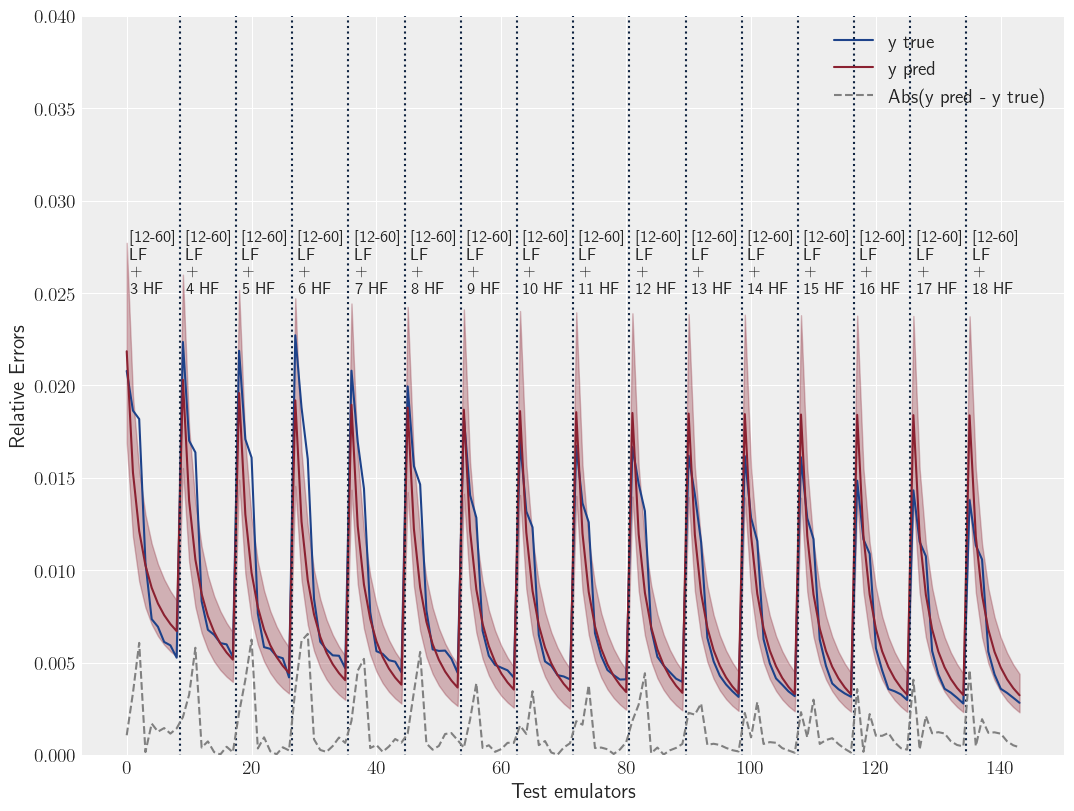

In [19]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

plt.plot(range(len(y_true)), y_true, label=r"y true", color=colors[2])
plt.plot(range(len(y_true)), y_pred, label=r"y pred", color=colors[0])

hf_size = len(set(n_hf))
lf_size = len(set(n_lf))

plt.vlines(
    [
        lf_size - 0.5 + lf_size * i for i in range(hf_size - 1)
    ],
    ymin=-0.01, ymax=0.07, ls="dotted", color=colors[3])

for i in range(hf_size):
    plt.text(
        0.5 + lf_size * i,
        0.025,
        "[12-60]\nLF\n+\n{} HF".format(3 + i),
        fontdict={"fontsize" : 12}
    )


plt.fill_between(range(len(y_true)), y1=y_pred_lower, y2=y_pred_upper, alpha=0.3, color=colors[0])

plt.plot(np.abs(y_pred - y_true), ls="--", color="grey", label=r"Abs(y pred - y true)" )

plt.ylim((0.0, 0.04))
plt.ylabel("Relative Errors")
plt.xlabel("Test emulators")
plt.legend()

fig.savefig("../../../Latex/mf_boxsize_paper/images/budget_all_test_errors_dgmgp.pdf", bbox_inches='tight', pad_inches=0.075)


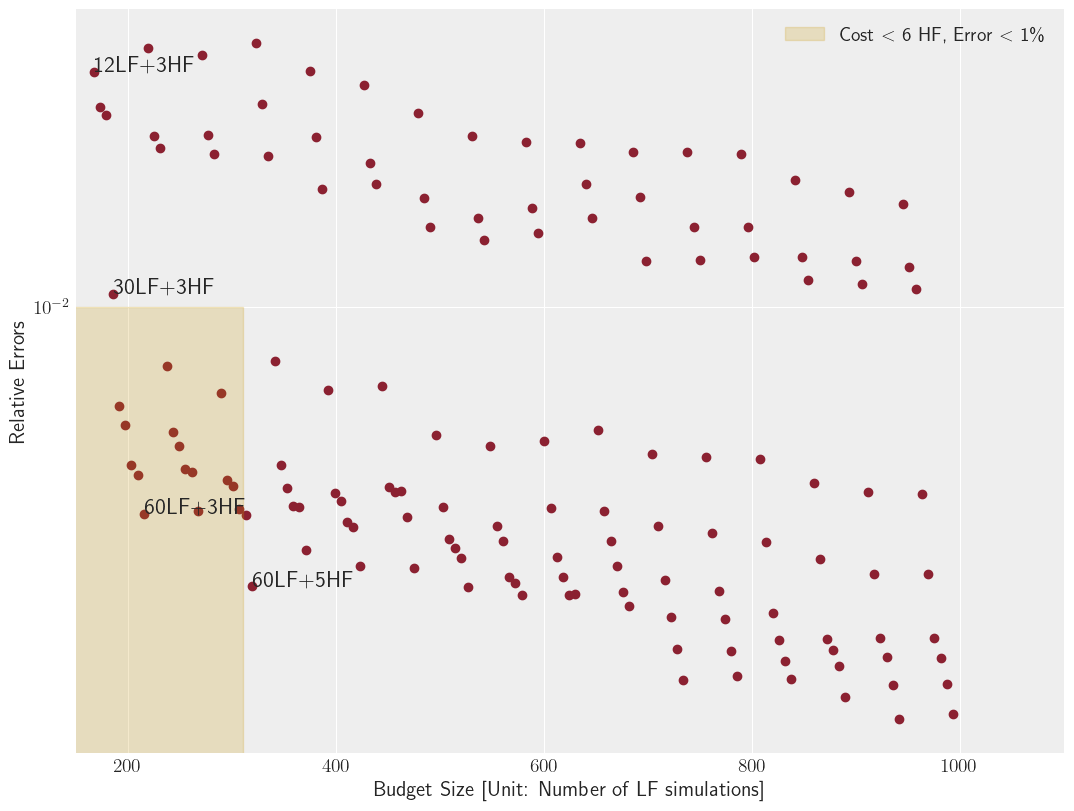

In [20]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

cost = 140 / (1 + 1.7)

ax.scatter(
    n_lf + n_hf * cost, y_true,
    color=colors[0]
)
ax.set_yscale("log")

ax.fill_between(
    np.linspace(0, 6 * cost), y1=0.01, alpha=0.2, color=colors[1],
    label="Cost $<$ 6 HF, Error $<$ 1\%"
)

for i,(x,y) in enumerate(zip(n_lf + n_hf * cost, y_true)):
    # if i < 40:
    #     plt.text(x, y, i)    
    if i in [0, 3, 8, 26]:
        plt.text(x, y, "{}LF+{}HF".format(int(n_lf[i]), int(n_hf[i])))

ax.set_xlim(150, 1100)
ax.legend()

plt.xlabel("Budget Size [Unit: Number of LF simulations]")
plt.ylabel("Relative Errors")

fig.savefig("../../../Latex/mf_boxsize_paper/images/budget_all_costs_errors_dgmgp.pdf", bbox_inches='tight', pad_inches=0.075)

## Posterior extrapolation beyond the fitting range

In [21]:
def plot_lf_fn(
        lf_min: int, lf_max: int, selected_hf: int,
        rho1_median, rho2_median, theta_median, nu1_median, nu2_median, nu0_median,
        rho1_upper,  rho2_upper,  theta_upper,  nu1_upper,  nu2_upper,  nu0_upper,
        rho1_lower,  rho2_lower,  theta_lower,  nu1_lower,  nu2_lower,  nu0_lower,
        color,
        ):
    """
    Plot the error(n_lf) and overplot true errors(n_hf == selected_hf)
    """
    all_n_lfs = np.arange(lf_min, lf_max)

    ind = x_train[:, 0] == selected_hf
    data_lf    = x_train[ind, 1]
    data_error = y_train[ind, 0]

    # Predictions
    plt.plot(
        all_n_lfs,
        budget_size_fn(all_n_lfs, selected_hf, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median),
        label="Estimated: {} HF".format(selected_hf),
        color=color
    )
    plt.fill_between(
        all_n_lfs,
        y1=budget_size_fn(all_n_lfs, selected_hf, theta_lower,  rho1_lower,  rho2_lower,  nu1_upper,  nu2_upper,  nu0_upper),
        y2=budget_size_fn(all_n_lfs, selected_hf, theta_upper,  rho1_upper,  rho2_upper,  nu1_lower,  nu2_lower,  nu0_lower),
        color=color,
        alpha=0.25
    )
    # Ture values
    plt.plot(data_lf, data_error, label="data: {}HF".format(selected_hf), ls="--", marker="o", color=color)

def plot_hf_fn(
        hf_min: int, hf_max: int, selected_lf: int,
        rho1_median, rho2_median, theta_median, nu1_median, nu2_median, nu0_median,
        rho1_upper,  rho2_upper,  theta_upper,  nu1_upper,  nu2_upper,  nu0_upper,
        rho1_lower,  rho2_lower,  theta_lower,  nu1_lower,  nu2_lower,  nu0_lower,
        color,
        ):
    """
    Plot the error(n_hf) and overplot true errors(n_lf == selected_lf)
    """
    all_n_hfs = np.arange(hf_min, hf_max)

    ind = x_train[:, 1] == selected_lf
    data_hf    = x_train[ind, 0]
    data_error = y_train[ind, 0]

    # Predictions
    plt.plot(
        all_n_hfs,
        budget_size_fn(selected_lf, all_n_hfs, theta_median, rho1_median, rho2_median, nu1_median, nu2_median, nu0_median),
        label="Estimated: {} LF".format(selected_lf),
        color=color
    )
    plt.fill_between(
        all_n_hfs,
        y1=budget_size_fn(selected_lf, all_n_hfs, theta_lower,  rho1_lower,  rho2_lower,  nu1_upper,  nu2_upper,  nu0_upper),
        y2=budget_size_fn(selected_lf, all_n_hfs, theta_upper,  rho1_upper,  rho2_upper,  nu1_lower,  nu2_lower,  nu0_lower),
        color=color,
        alpha=0.25
    )
    # Ture values
    plt.plot(data_hf, data_error, label="data: {}LF".format(selected_lf), ls="--", marker="o", color=color)


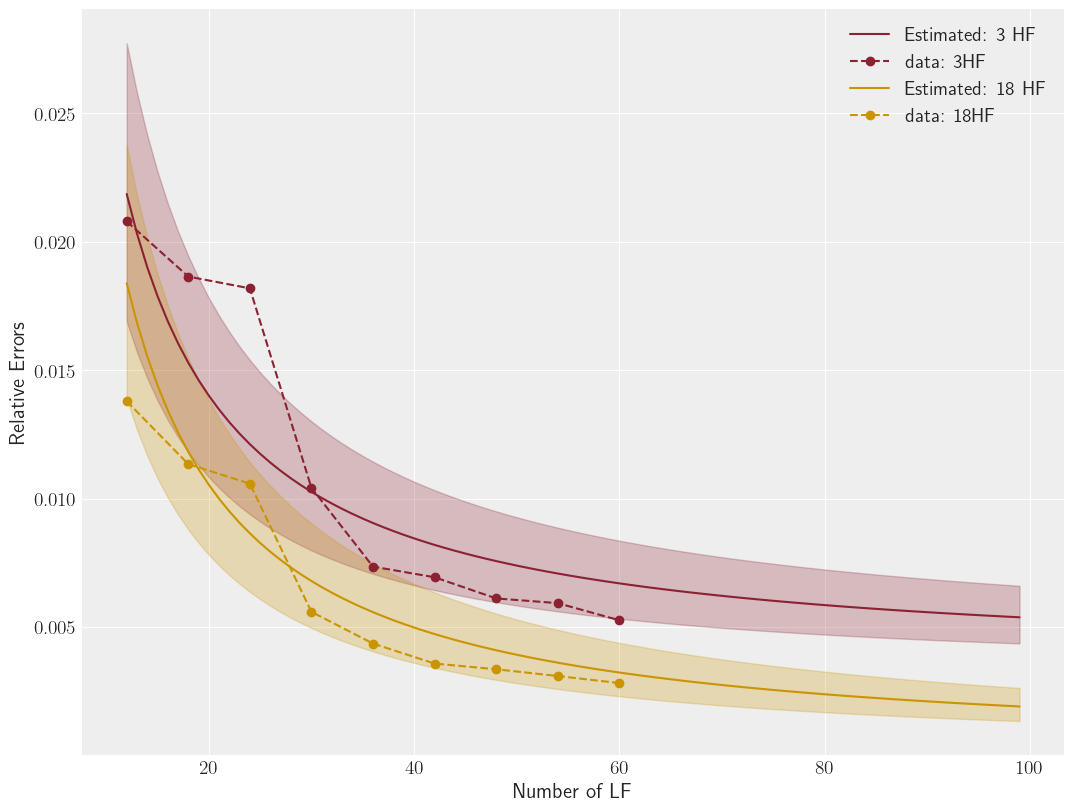

In [22]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

plot_lf_fn(
    lf_min=12,
    lf_max=100,
    selected_hf=3,
    rho1_median=rho1_median,
    rho2_median=rho2_median,
    theta_median=theta_median,
    nu1_median=nu1_median,
    nu2_median=nu2_median,
    nu0_median=nu0_median,
    rho1_upper=rho1_upper,
    rho2_upper=rho2_upper,
    theta_upper=theta_upper,
    nu1_upper=nu1_upper,
    nu2_upper=nu2_upper,
    nu0_upper=nu0_upper,
    rho1_lower=rho1_lower,
    rho2_lower=rho2_lower,
    theta_lower=theta_lower,
    nu1_lower=nu1_lower,
    nu2_lower=nu2_lower,
    nu0_lower=nu0_lower,
    color=colors[0]
)


plot_lf_fn(
    lf_min=12,
    lf_max=100,
    selected_hf=18,
    rho1_median=rho1_median,
    rho2_median=rho2_median,
    theta_median=theta_median,
    nu1_median=nu1_median,
    nu2_median=nu2_median,
    nu0_median=nu0_median,
    rho1_upper=rho1_upper,
    rho2_upper=rho2_upper,
    theta_upper=theta_upper,
    nu1_upper=nu1_upper,
    nu2_upper=nu2_upper,
    nu0_upper=nu0_upper,
    rho1_lower=rho1_lower,
    rho2_lower=rho2_lower,
    theta_lower=theta_lower,
    nu1_lower=nu1_lower,
    nu2_lower=nu2_lower,
    nu0_lower=nu0_lower,
    color=colors[1]
)

plt.xlabel("Number of LF")
plt.ylabel("Relative Errors")
plt.legend()
fig.savefig("../../../Latex/mf_boxsize_paper/images/budget_inferred_LR_error_dgmgp.pdf", bbox_inches='tight', pad_inches=0.075)

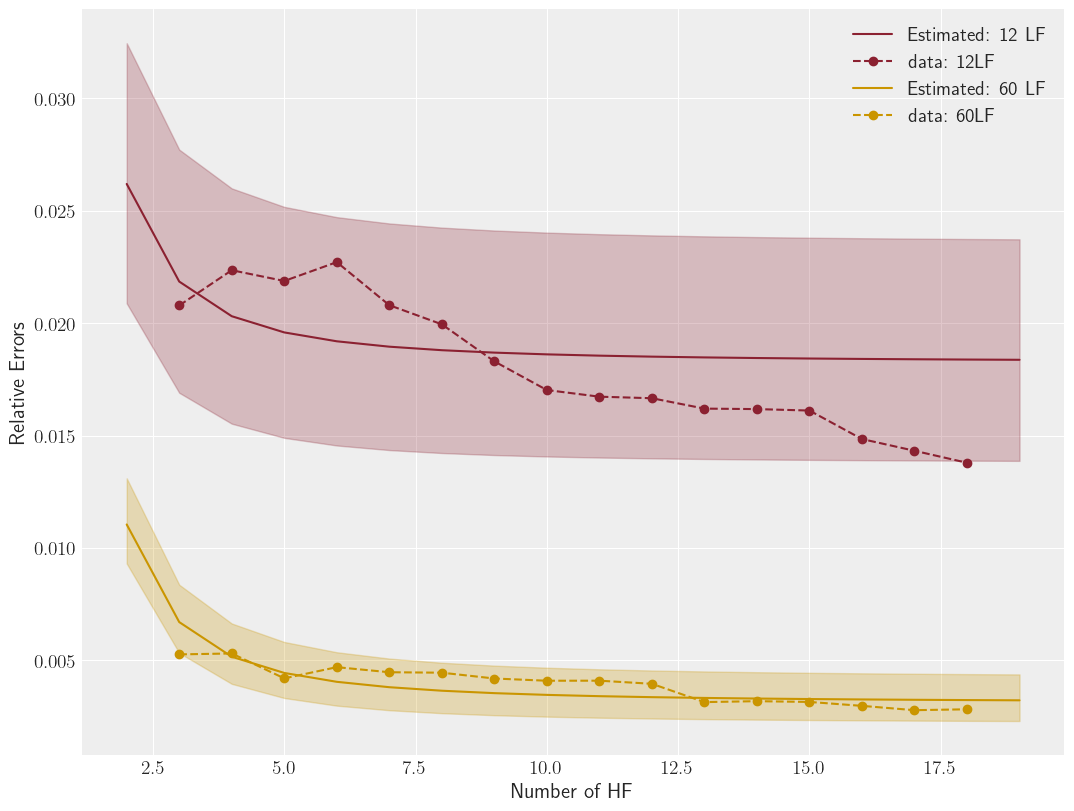

In [23]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)


plot_hf_fn(
    hf_min=2,
    hf_max=20,
    selected_lf=12,
    rho1_median=rho1_median,
    rho2_median=rho2_median,
    theta_median=theta_median,
    nu1_median=nu1_median,
    nu2_median=nu2_median,
    nu0_median=nu0_median,
    rho1_upper=rho1_upper,
    rho2_upper=rho2_upper,
    theta_upper=theta_upper,
    nu1_upper=nu1_upper,
    nu2_upper=nu2_upper,
    nu0_upper=nu0_upper,
    rho1_lower=rho1_lower,
    rho2_lower=rho2_lower,
    theta_lower=theta_lower,
    nu1_lower=nu1_lower,
    nu2_lower=nu2_lower,
    nu0_lower=nu0_lower,
    color=colors[0],
)



plot_hf_fn(
    hf_min=2,
    hf_max=20,
    selected_lf=60,
    rho1_median=rho1_median,
    rho2_median=rho2_median,
    theta_median=theta_median,
    nu1_median=nu1_median,
    nu2_median=nu2_median,
    nu0_median=nu0_median,
    rho1_upper=rho1_upper,
    rho2_upper=rho2_upper,
    theta_upper=theta_upper,
    nu1_upper=nu1_upper,
    nu2_upper=nu2_upper,
    nu0_upper=nu0_upper,
    rho1_lower=rho1_lower,
    rho2_lower=rho2_lower,
    theta_lower=theta_lower,
    nu1_lower=nu1_lower,
    nu2_lower=nu2_lower,
    nu0_lower=nu0_lower,
    color=colors[1],
)


plt.legend()

plt.xlabel("Number of HF")
plt.ylabel("Relative Errors")

plt.savefig("../../../Latex/mf_boxsize_paper/images/budget_inferred_HR_error_dgmgp.pdf", bbox_inches='tight', pad_inches=0.075)

## Budget Size estimation

In [24]:
n_estimated = lambda cost, rho, nu : (rho / cost) ** (5 / (5 + nu))

size_l1 = n_estimated(1, rho1_median, nu1_median)
size_l2 = n_estimated(1.7, rho2_median, nu2_median)
size_h  = n_estimated(140, 1, nu0_median)

(size_l1 / size_h, size_l2 / size_h)

(10.899188295699087, 8.481810502656794)

# 

In [ ]:
add_lf_list = [70, 80, 90, 100, 150, 200, 250, 300, 360]
file_list = [
     "../data/output/Matterpower_70_res128box256_3_res512box256_z0_ind-57-58-59/AR1/pred_exacts",    
     "../data/output/Matterpower_80_res128box256_3_res512box256_z0_ind-57-58-59/AR1/pred_exacts",
     "../data/output/Matterpower_90_res128box256_3_res512box256_z0_ind-57-58-59/AR1/pred_exacts",    
    "../data/output/Matterpower_100_res128box256_3_res512box256_z0_ind-57-58-59/AR1/pred_exacts",
    "../data/output/Matterpower_150_res128box256_3_res512box256_z0_ind-57-58-59/AR1/pred_exacts",
    "../data/output/Matterpower_200_res128box256_3_res512box256_z0_ind-57-58-59/AR1/pred_exacts",
    "../data/output/Matterpower_250_res128box256_3_res512box256_z0_ind-57-58-59/AR1/pred_exacts",
    "../data/output/Matterpower_300_res128box256_3_res512box256_z0_ind-57-58-59/AR1/pred_exacts",
    "../data/output/Matterpower_360_res128box256_3_res512box256_z0_ind-57-58-59/AR1/pred_exacts",    
]
errors = [
    np.mean(np.abs(np.loadtxt(f) - 1)) for f in file_list
]

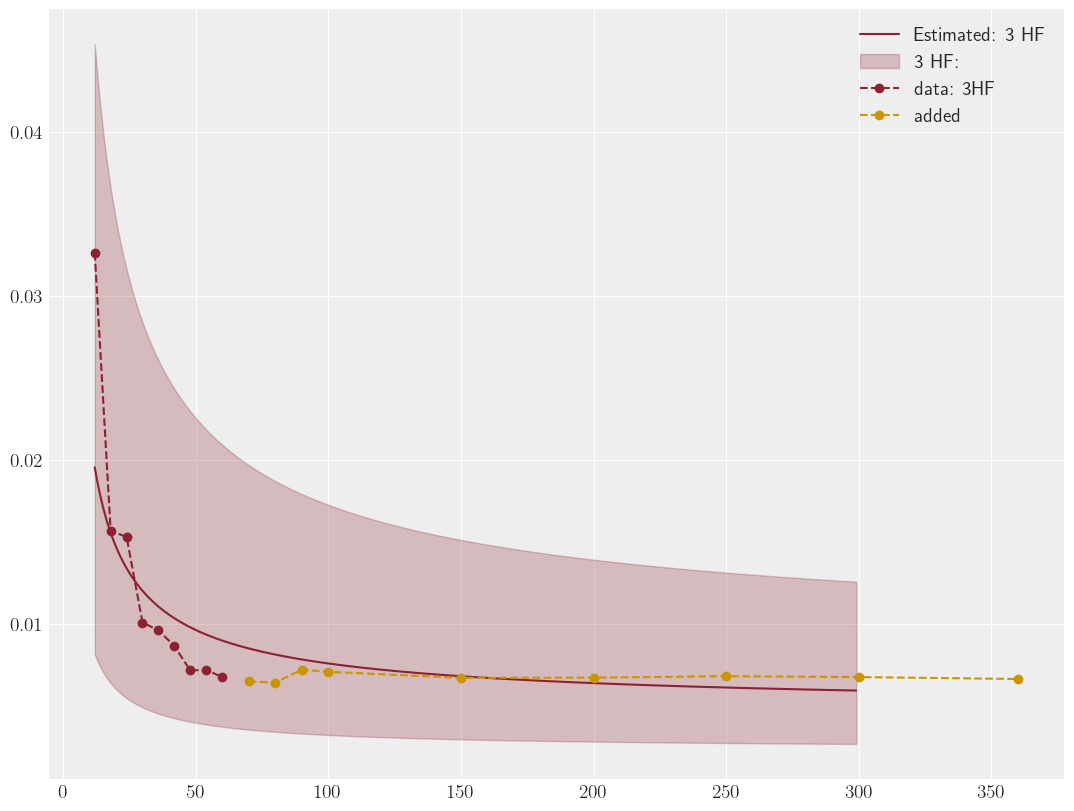

In [ ]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

all_n_lfs = np.arange(12, 300)

num_lf = 3

ind = x_train[:, 1] == num_lf
data_lf    = x_train[ind, 0]
data_error = y_train[ind, 0]

plt.plot(
    all_n_lfs,
    budget_size_fn(all_n_lfs, num_lf, theta_mode, rho_mode, nu_mode, nu2_mode),
    label="Estimated: 3 HF",
    color=colors[0]
)
plt.fill_between(
    all_n_lfs,
    y1=budget_size_fn(all_n_lfs, num_lf, theta_lower, rho_lower, nu_upper, nu2_upper),
    y2=budget_size_fn(all_n_lfs, num_lf, theta_upper, rho_upper, nu_lower, nu2_lower),
    label="{} HF: ".format(num_lf),
    color=colors[0],
    alpha=0.25
)
plt.plot(data_lf, data_error, label="data: {}HF".format(num_lf), ls="--", marker="o", color=colors[0])
plt.plot(add_lf_list, errors, label="added", ls="--", marker="o", color=colors[1])
plt.legend()